# TP 5 - Procesamiento de Imagenes
Grupo 4 <br>
Integrantes:
- Pablo Smolkin
- Pedro Carranza Vélez
- Philippe Dutriez Diaz
- Francisco Daniel Ledesma

Nota: Las funciones utilizadas se encuentran en el archivo functions.py

In [1]:
from sys import path
from os.path import realpath
path.append(realpath("../")) # Makes it works everywhere
from common.functions import *

In [2]:
from functions import *

In [3]:
%load_ext autoreload
%autoreload 2

# Restauracion de Imagenes - Trabajo de investigacion

In [4]:
lena = Image.open('img/lena_gray.tif')

## 1 - Inverse Filtering
Dado que se conoce la PSF (transformada de Fourier del proceso de degradacion h(x,y)) podemos aplicar el filtro inverso:
\begin{equation*}
    R(\omega_x,\omega_y) = \dfrac{1}{H(\omega_x,\omega_y)}
\end{equation*}

### a - Blur
Obtenemos el efecto de borroso aplicando un filtro pasabajos gaussiano y luego aplicamos filtro inverso

MSE: 1.032625155103909e-27


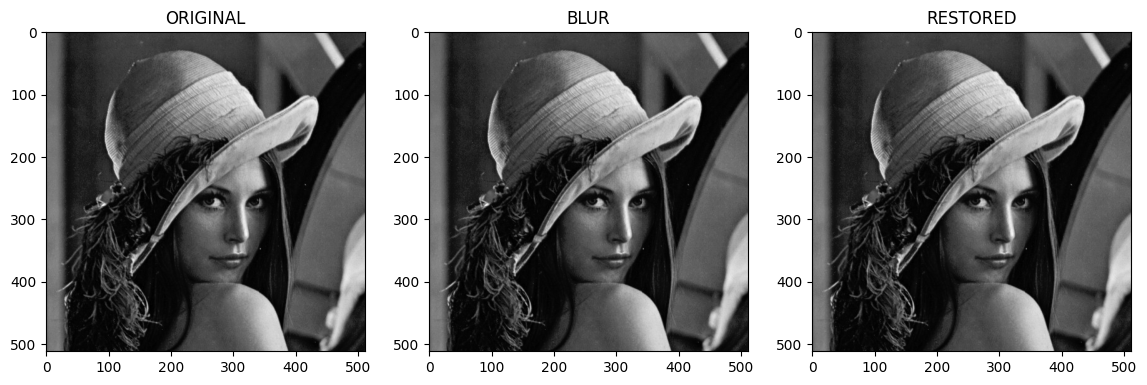

In [5]:
kernel = gaussian_kernel(size=5,sigma=0.2)
kernel = resize_kernel(lena.size,kernel)

img_blurd = apply_filter(lena,kernel)

restored = apply_inverse_filter(img_blurd,kernel)

images = {'ORIGINAL':lena,
          'BLUR':img_blurd,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)

MSE: 2.3022390915722444e-19


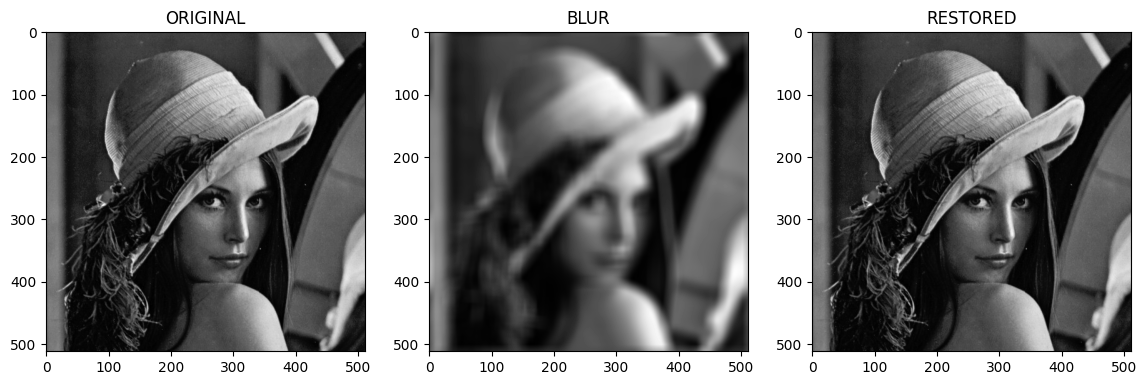

In [6]:
order = 512//24
kernel = np.ones((order,order),dtype=float)/(order*order) #Lowpass unit kernel
kernel = resize_kernel(lena.size,kernel)

img_blurd = apply_filter(lena,kernel)

restored = apply_inverse_filter(img_blurd,kernel)

images = {'ORIGINAL':lena,
          'BLUR':img_blurd,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)

### b - Blur + Noise

MSE: 6388823072.295677


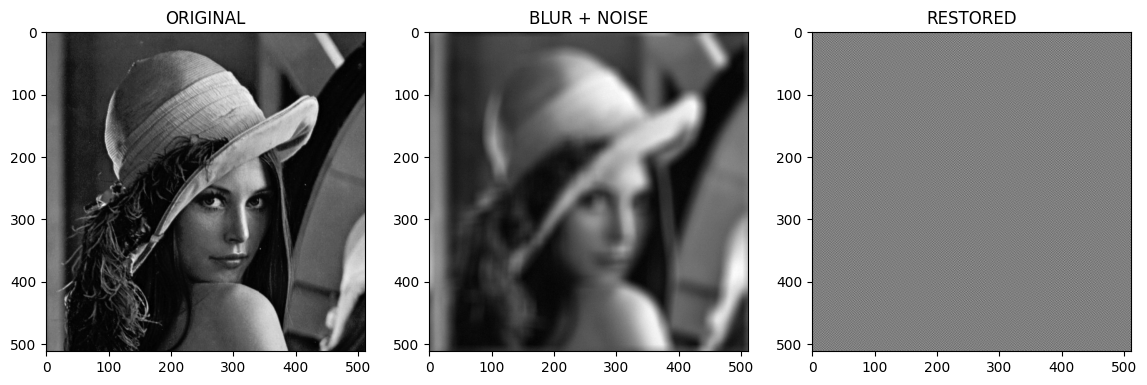

In [7]:
snr = 30
noise = normal_noise(img_blurd,snr)
img_blurd_noisy = img_blurd + noise
img_blurd_noisy = np.clip(img_blurd_noisy, 0, 255)

restored = apply_inverse_filter(img_blurd_noisy,kernel)
images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'RESTORED':restored
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED']).var())
compare(images)

## 1 - Wiener
Este filtro intenta resolver el problema de la amplificación del ruido buscando una solución de compromiso entre la calidad de la restauración y la amplificación del ruido. Suponiendo que la señal **s** y el ruido **n** son procesos aleatorios con media cero, si deseamos estimar la señal usando un estimador lineal:

\begin{equation*}
\hat{s}(x,y) = (s(x,y) + n(x,y))*h(x,y)
\end{equation*}

Entonces la ecuación del filtro de Wiener es:

\begin{equation*}
W(w_x,w_y) = \dfrac{H^*(w_x,w_y)S_{xx}(w_x,w_y)}{|H(w_x,w_y)|^2S_{xx}(w_x,w_y) + S_{nn}(w_x,w_y)}
\end{equation*}

Siendo $S_{xx}$ y $S_{nn}$ las densidades espectrales del ruido y H la respuesta en frecuencia del filtro degradador.

In [8]:
restored_wiener = apply_wiener_filter(lena, img_blurd_noisy, noise, kernel)

MSE: 91.13084851986609


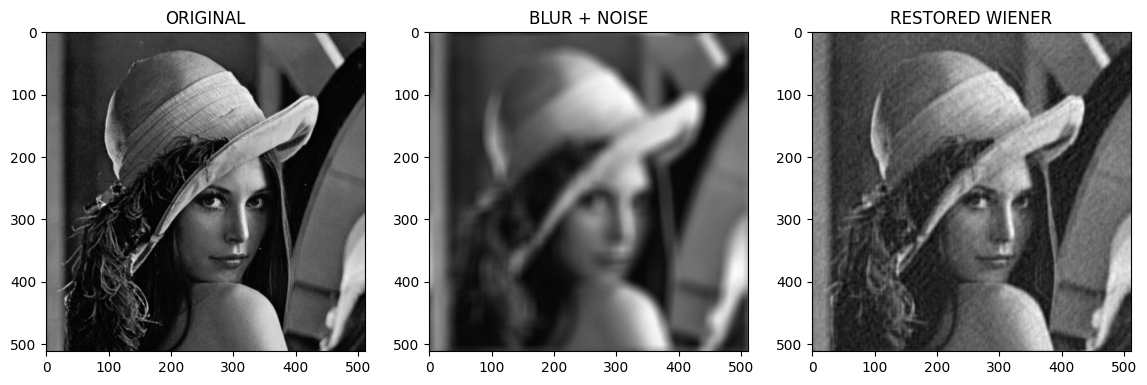

In [9]:
images = {'ORIGINAL':lena,
          'BLUR + NOISE':img_blurd_noisy,
          'RESTORED WIENER':restored_wiener
        }

print('MSE:', (images['ORIGINAL'] - images['RESTORED WIENER']).var())
compare(images)